In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [8]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [9]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [10]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [11]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [12]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [13]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
615204               2020-08-31           2020-08-29            2020-08-18   
615205               2020-08-31           2020-08-29            2020-08-18   
615206               2020-08-31           2020-08-29            2020-08-18   
615207               2020-08-31           2020-08-29            2020-08-18   
615208               2020-08-31           2020-08-29            2020-08-18   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
615204             2020-08-11 00:00:00                   NaT   
615205             2020-08-11 00:00:00                   NaT   
615206             2020-08-11 00:00:00                   NaT   
615207             2020-08-11 00:00:00                   NaT   
615208             2020-08-11 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
615204                    NaT       Puerto carreño          Vichada      Leve   
615205                    NaT       Puerto carreño          Vichada      Leve   
615206                    NaT       Puerto carreño          Vichada      Leve   
615207                    NaT       Puerto carreño          Vichada      Leve   
615208                    NaT       Puerto carreño          Vichada      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
615204            Casa  ...                10 - 20    F               NaN   
615205            Casa  ...                30 - 40    M               NaN   
615206            Casa  ...                20 - 30    M               NaN   
615207            Casa  ...                50 - 60    F               NaN   
615208            Casa  ...                50 - 60    F               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Casos activos VS Departamento (Estado)

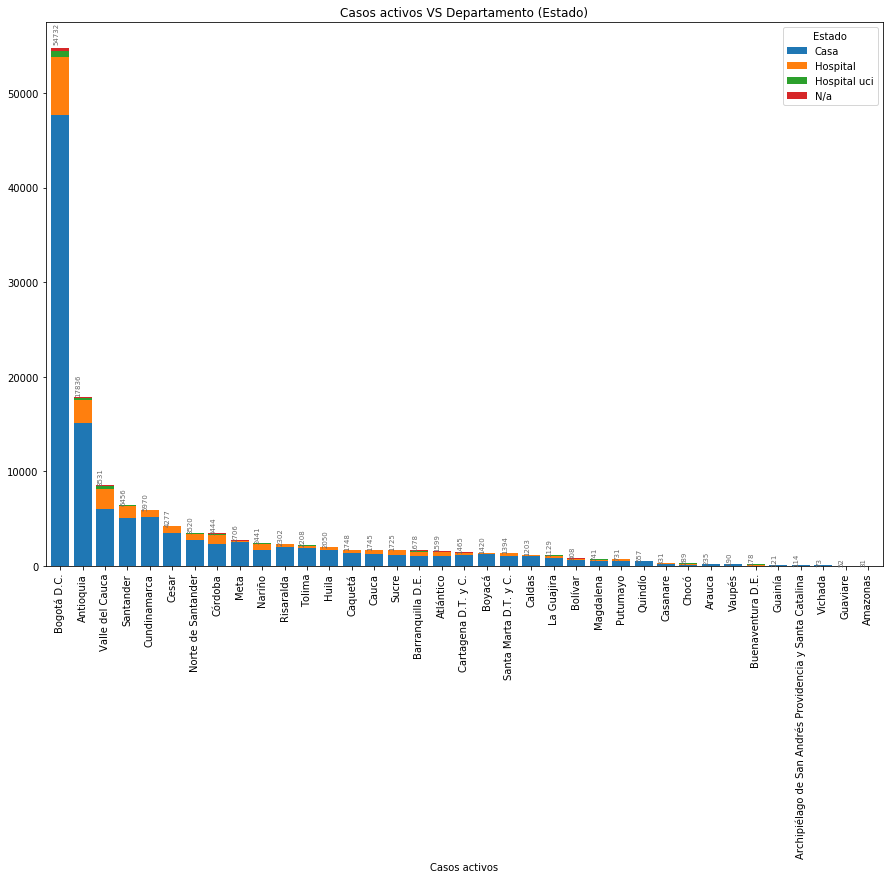

In [14]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [15]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         47667.0    6194.0   
Antioquia                                           15146.0    2366.0   
Valle del Cauca                                      6071.0    2082.0   
Santander                                            5066.0    1300.0   
Cundinamarca                                         5164.0     745.0   
Cesar                                                3534.0     658.0   
Norte de Santander                                   2777.0     600.0   
Córdoba                                              2351.0     945.0   
Meta                                                 2499.0     177.0   
Nariño                                               1699.0     660.0   
Risaralda                                            2054.0     227.0   
Tolima                                               1857.0     296.0   
Huila                                                1668.0     359.0   
Caquetá                                              1428.0     293.0   
Cauca                                                1272.0     393.0   
Sucre                                                1147.0     533.0   
Barranquilla D.E.                                    1076.0     451.0   
Atlántico                                            1110.0     343.0   
Cartagena D.T. y C.                                  1190.0     198.0   
Boyacá                                               1237.0     155.0   
Santa Marta D.T. y C.                                1101.0     263.0   
Caldas                                               1051.0     128.0   
La Guajira                                            847.0     245.0   
Bolívar                                               615.0     147.0   
Magdalena                                             506.0     177.0   
Putumayo                                              499.0     219.0   
Quindío                                               505.0      48.0   
Casanare                                              265.0      55.0   
Chocó                                                 121.0     138.0   
Arauca                                                214.0      17.0   
Vaupés                                                180.0      10.0   
Buenaventura D.E.                                      54.0     100.0   
Guainía                                               119.0       2.0   
Archipiélago de San Andrés Providencia y Santa ...    102.0      11.0   
Vichada                                                71.0       2.0   
Guaviare                                               45.0       5.0   
Amazonas                                               22.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                540.0  331.0   
Antioquia                                                  207.0  117.0   
Valle del Cauca                                            261.0  117.0   
Santander                                                   63.0   27.0   
Cundinamarca                                                30.0   31.0   
Cesar                                                       65.0   20.0   
Norte de Santander                                         122.0   21.0   
Córdoba                                                     61.0   87.0   
Meta                                                        13.0   17.0   
Nariño                                                      49.0   33.0   
Risaralda                                                   11.0   10.0   
Tolima                                                      25.0   30.0   
Huila                                                        9.0   14.0   
Caquetá                    

### - Recuperados y Fallecidos VS Departamento

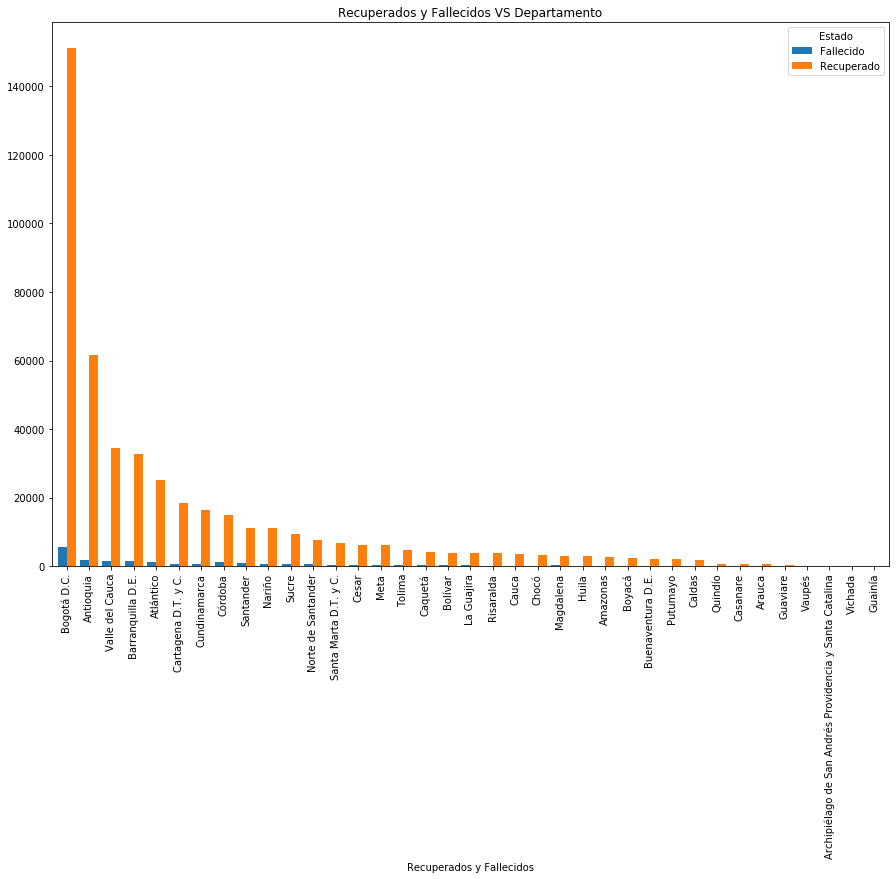

In [16]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=('Recuperados y Fallecidos VS Departamento'))
ax.set_xlabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [17]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            5437.0    151131.0
Antioquia                                              1694.0     61466.0
Valle del Cauca                                        1598.0     34413.0
Barranquilla D.E.                                      1610.0     32843.0
Atlántico                                              1290.0     25108.0
Cartagena D.T. y C.                                     520.0     18458.0
Cundinamarca                                            659.0     16499.0
Córdoba                                                1303.0     14991.0
Santander                                               774.0     10981.0
Nariño                                                  513.0     11132.0
Sucre                                                   491.0      9493.0
Norte de Santander                                      641.0      7689.0
Santa Marta D.T. y C.                                   353.0      6784.0
Cesar                                                   296.0      6242.0
Meta                                                    200.0      6057.0
Tolima                                                  184.0      4824.0
Caquetá                                                 197.0      4122.0
Bolívar                                                 182.0      3834.0
La Guajira                                              231.0      3779.0
Risaralda                                               108.0      3815.0
Cauca                                                   158.0      3382.0
Chocó                                                   136.0      3297.0
Magdalena                                               329.0      2859.0
Huila                                                   137.0      2980.0
Amazonas                                                111.0      2559.0
Boyacá                                                   78.0      2326.0
Buenaventura D.E.                                       158.0      2066.0
Putumayo                                                133.0      2031.0
Caldas                                                   56.0      1705.0
Quindío                                                  38.0       721.0
Casanare                                                 24.0       705.0
Arauca                                                   17.0       673.0
Guaviare                                                  1.0       220.0
Vaupés                                                    1.0       149.0
Archipiélago de San Andrés Providencia y Santa ...        1.0       104.0
Vichada                                                   2.0        20.0
Guainía                                                   2.0        17.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

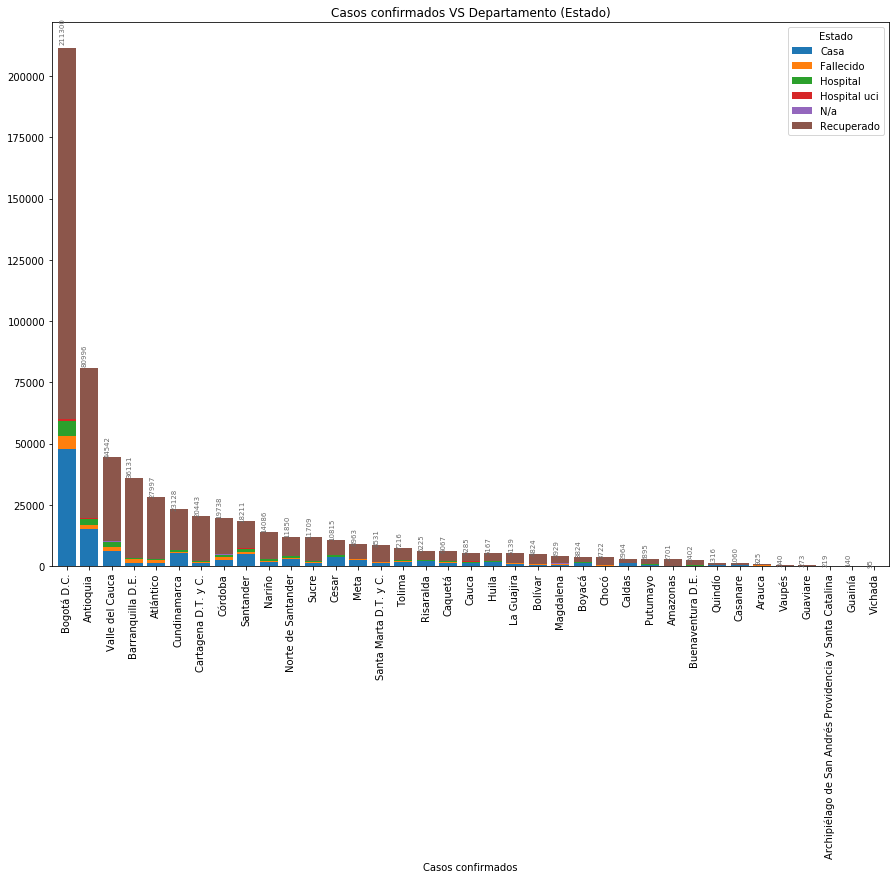

In [18]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [19]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         47667.0     5437.0   
Antioquia                                           15146.0     1694.0   
Valle del Cauca                                      6071.0     1598.0   
Barranquilla D.E.                                    1076.0     1610.0   
Atlántico                                            1110.0     1290.0   
Cundinamarca                                         5164.0      659.0   
Cartagena D.T. y C.                                  1190.0      520.0   
Córdoba                                              2351.0     1303.0   
Santander                                            5066.0      774.0   
Nariño                                               1699.0      513.0   
Norte de Santander                                   2777.0      641.0   
Sucre                                                1147.0      491.0   
Cesar                                                3534.0      296.0   
Meta                                                 2499.0      200.0   
Santa Marta D.T. y C.                                1101.0      353.0   
Tolima                                               1857.0      184.0   
Risaralda                                            2054.0      108.0   
Caquetá                                              1428.0      197.0   
Cauca                                                1272.0      158.0   
Huila                                                1668.0      137.0   
La Guajira                                            847.0      231.0   
Bolívar                                               615.0      182.0   
Magdalena                                             506.0      329.0   
Boyacá                                               1237.0       78.0   
Chocó                                                 121.0      136.0   
Caldas                                               1051.0       56.0   
Putumayo                                              499.0      133.0   
Amazonas                                               22.0      111.0   
Buenaventura D.E.                                      54.0      158.0   
Quindío                                               505.0       38.0   
Casanare                                              265.0       24.0   
Arauca                                                214.0       17.0   
Vaupés                                                180.0        1.0   
Guaviare                                               45.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...    102.0        1.0   
Guainía                                               119.0        2.0   
Vichada                                                71.0        2.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6194.0         540.0   
Antioquia                                             2366.0         207.0   
Valle del Cauca                                       2082.0         261.0   
Barranquilla D.E.                                      451.0          48.0   
Atlántico                                              343.0          54.0   
Cundinamarca                                           745.0          30.0   
Cartagena D.T. y C.                                    198.0          43.0   
Córdoba                                                945.0          61.0   
Santander                                             1300.0          63.0   
Nariño                                                 660.0          49.0   
Norte de Santander                                     600.0         122.0   
Sucre                                                  533.0          22.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

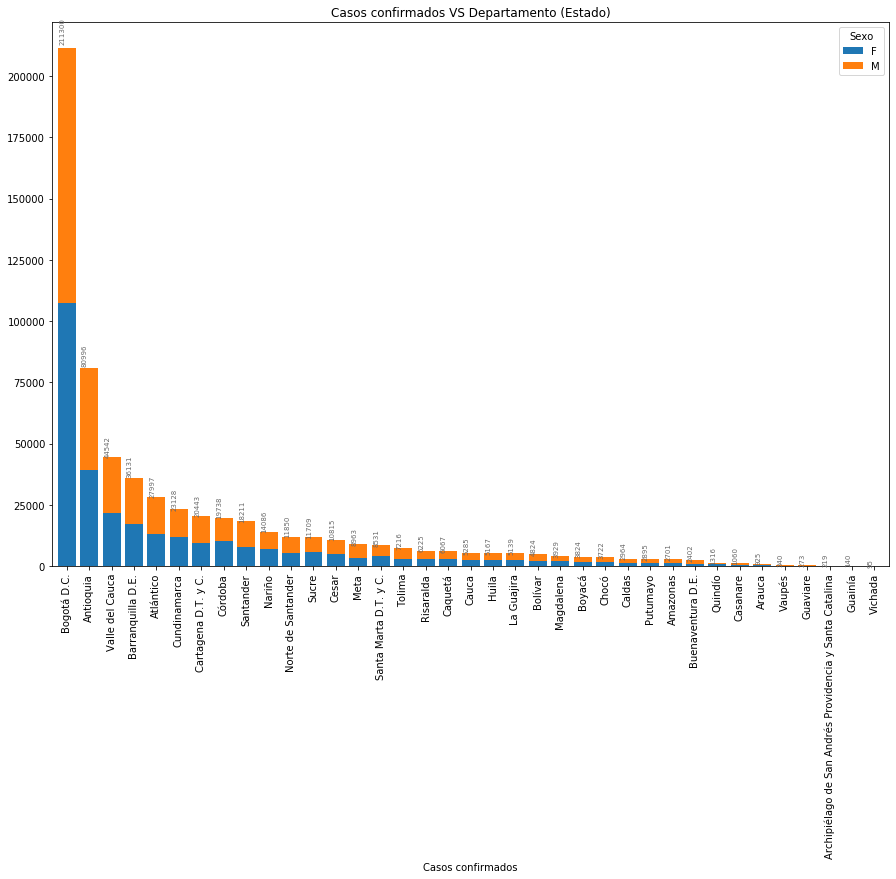

In [20]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [21]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         107215  104085  211300
Antioquia                                            39026   41970   80996
Valle del Cauca                                      21610   22932   44542
Barranquilla D.E.                                    17043   19088   36131
Atlántico                                            13263   14734   27997
Cundinamarca                                         11739   11389   23128
Cartagena D.T. y C.                                   9421   11022   20443
Córdoba                                              10154    9584   19738
Santander                                             7969   10242   18211
Nariño                                                6772    7314   14086
Norte de Santander                                    5498    6352   11850
Sucre                                                 5684    6025   11709
Cesar                                                 5072    5743   10815
Meta                                                  3453    5510    8963
Santa Marta D.T. y C.                                 4284    4247    8531
Tolima                                                2828    4388    7216
Risaralda                                             2995    3230    6225
Caquetá                                               2999    3068    6067
Cauca                                                 2503    2782    5285
Huila                                                 2564    2603    5167
La Guajira                                            2602    2537    5139
Bolívar                                               2248    2576    4824
Magdalena                                             1990    1939    3929
Boyacá                                                1777    2047    3824
Chocó                                                 1763    1959    3722
Caldas                                                1389    1575    2964
Putumayo                                              1327    1568    2895
Amazonas                                              1167    1534    2701
Buenaventura D.E.                                      900    1502    2402
Quindío                                                652     664    1316
Casanare                                               440     620    1060
Arauca                                                 306     619     925
Vaupés                                                 143     197     340
Guaviare                                                49     224     273
Archipiélago de San Andrés Providencia y Santa ...     126      93     219
Guainía                                                 60      80     140
Vichada                                                 27      68      95

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

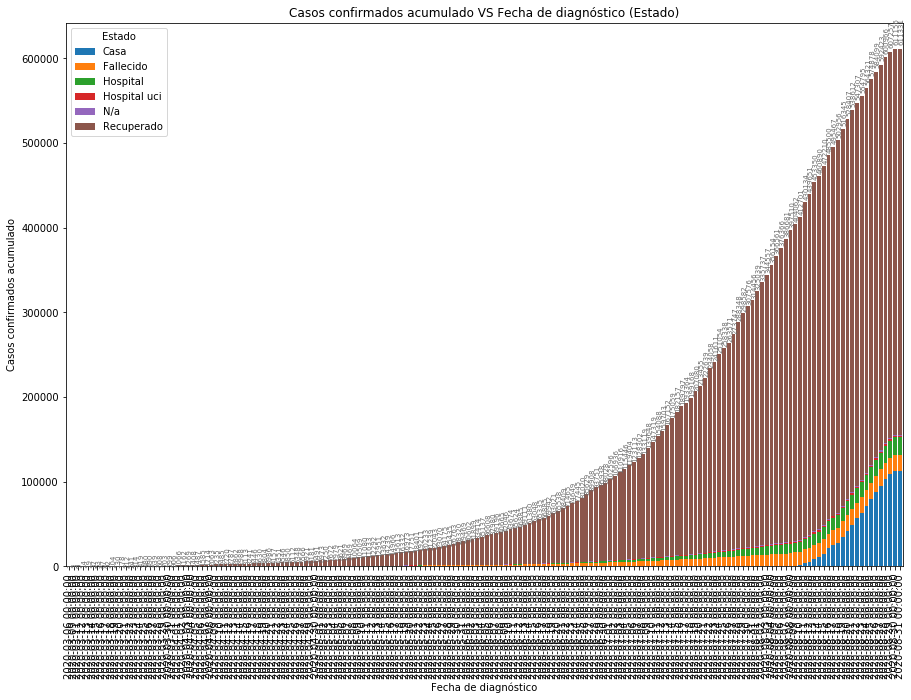

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-31            112328.0    19459.0   20487.0        1853.0  1265.0   
2020-08-30            112159.0    19459.0   20481.0        1853.0  1265.0   
2020-08-29            108557.0    19456.0   20193.0        1851.0  1265.0   
2020-08-28            102712.0    19420.0   19875.0        1839.0  1264.0   
2020-08-27             94972.0    19343.0   19411.0        1795.0  1262.0   
2020-08-26             87415.0    19253.0   18932.0        1775.0  1255.0   
2020-08-25             79423.0    19119.0   18433.0        1754.0  1246.0   
2020-08-24             70707.0    19002.0   18001.0        1752.0  1238.0   
2020-08-23             63046.0    18856.0   17547.0        1741.0  1227.0   
2020-08-22             56447.0    18752.0   17239.0        1738.0  1224.0   
2020-08-21             49334.0    18580.0   16796.0        1734.0  1216.0   
2020-08-20             42013.0    18388.0   16318.0        1705.0  1199.0   
2020-08-19             35088.0    18067.0   15648.0        1650.0  1187.0   
2020-08-18             27428.0    17824.0   15120.0        1631.0  1173.0   
2020-08-17             24837.0    17598.0   14767.0        1622.0  1152.0   
2020-08-16             21111.0    17439.0   14450.0        1612.0  1143.0   
2020-08-15             14718.0    17167.0   14026.0        1603.0  1134.0   
2020-08-14             10457.0    16903.0   13583.0        1587.0  1125.0   
2020-08-13              8745.0    16678.0   13278.0        1575.0  1117.0   
2020-08-12              5314.0    16385.0   12806.0        1556.0  1102.0   
2020-08-11              3798.0    16050.0   12374.0        1533.0  1090.0   
2020-08-10              1512.0    15655.0   11745.0        1486.0  1071.0   
2020-08-09               879.0    15432.0   11413.0        1467.0  1053.0   
2020-08-08               393.0    15216.0   11100.0        1447.0  1046.0   
2020-08-07               150.0    14910.0   10810.0        1414.0  1031.0   
2020-08-06               107.0    14634.0   10488.0        1372.0  1011.0   
2020-08-05                93.0    14350.0   10223.0        1331.0   990.0   
2020-08-04                84.0    14067.0    9896.0        1289.0   968.0   
2020-08-03                77.0    13749.0    9587.0        1248.0   953.0   
2020-08-02                72.0    13412.0    9219.0        1222.0   933.0   
2020-08-01                71.0    13053.0    8837.0        1183.0   919.0   
2020-07-31                67.0    12711.0    8393.0        1150.0   899.0   
2020-07-30                64.0    12469.0    8147.0        1132.0   883.0   
2020-07-29                60.0    12175.0    7876.0        1090.0   862.0   
2020-07-28                53.0    11880.0    7556.0        1047.0   840.0   
2020-07-27                52.0    11325.0    7072.0         996.0   800.0   
2020-07-26                49.0    11001.0    6790.0         958.0   777.0   
2020-07-25                48.0    10757.0    6605.0         934.0   764.0   
2020-07-24                48.0    10454.0    6312.0         900.0   746.0   
2020-07-23                47.0    10150.0    6041.0         872.0   725.0   
2020-07-22                45.0     9775.0    5708.0         834.0   696.0   
2020-07-21                42.0     9330.0    5300.0         784.0   669.0   
2020-07-20                39.0     8980.0    5046.0         737.0   654.0   
2020-07-19                39.0     8707.0    4770.0         709.0   642.0   
2020-07-18                39.0     8427.0    4556.0         686.0   625.0   
2020-07-17                39.0     8186.0    4386.0         658.0   603.0   
2020-07-16                37.0     8009.0    4288.0         644.0   594.0   
2020-07-15                36.0     7723.0    4037.0         606.0   574.0   
2020-07-14                34.0     7427.0    3836.0         574.0   563.0   
2020-07-13                34.0     7143.0    3620.0         546.0   537.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

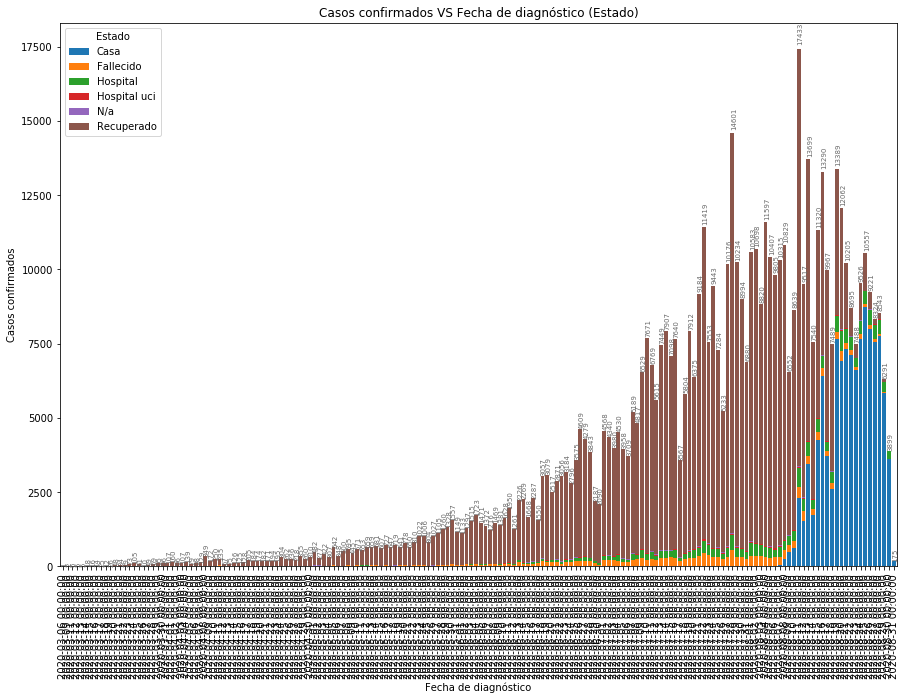

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-08-31             169.0        0.0       6.0           0.0   0.0   
2020-08-30            3602.0        3.0     288.0           2.0   0.0   
2020-08-29            5845.0       36.0     318.0          12.0   1.0   
2020-08-28            7740.0       77.0     464.0          44.0   2.0   
2020-08-27            7557.0       90.0     479.0          20.0   7.0   
2020-08-26            7992.0      134.0     499.0          21.0   9.0   
2020-08-25            8716.0      117.0     432.0           2.0   8.0   
2020-08-24            7661.0      146.0     454.0          11.0  11.0   
2020-08-23            6599.0      104.0     308.0           3.0   3.0   
2020-08-22            7113.0      172.0     443.0           4.0   8.0   
2020-08-21            7321.0      192.0     478.0          29.0  17.0   
2020-08-20            6925.0      321.0     670.0          55.0  12.0   
2020-08-19            7660.0      243.0     528.0          19.0  14.0   
2020-08-18            2591.0      226.0     353.0           9.0  21.0   
2020-08-17            3726.0      159.0     317.0          10.0   9.0   
2020-08-16            6393.0      272.0     424.0           9.0   9.0   
2020-08-15            4261.0      264.0     443.0          16.0   9.0   
2020-08-14            1712.0      225.0     305.0          12.0   8.0   
2020-08-13            3431.0      293.0     472.0          19.0  15.0   
2020-08-12            1516.0      335.0     432.0          23.0  12.0   
2020-08-11            2286.0      395.0     629.0          47.0  19.0   
2020-08-10             633.0      223.0     332.0          19.0  18.0   
2020-08-09             486.0      216.0     313.0          20.0   7.0   
2020-08-08             243.0      306.0     290.0          33.0  15.0   
2020-08-07              43.0      276.0     322.0          42.0  20.0   
2020-08-06              14.0      284.0     265.0          41.0  21.0   
2020-08-05               9.0      283.0     327.0          42.0  22.0   
2020-08-04               7.0      318.0     309.0          41.0  15.0   
2020-08-03               5.0      337.0     368.0          26.0  20.0   
2020-08-02               1.0      359.0     382.0          39.0  14.0   
2020-08-01               4.0      342.0     444.0          33.0  20.0   
2020-07-31               3.0      242.0     246.0          18.0  16.0   
2020-07-30               4.0      294.0     271.0          42.0  21.0   
2020-07-29               7.0      295.0     320.0          43.0  22.0   
2020-07-28               1.0      555.0     484.0          51.0  40.0   
2020-07-27               3.0      324.0     282.0          38.0  23.0   
2020-07-26               1.0      244.0     185.0          24.0  13.0   
2020-07-25               0.0      303.0     293.0          34.0  18.0   
2020-07-24               1.0      304.0     271.0          28.0  21.0   
2020-07-23               2.0      375.0     333.0          38.0  29.0   
2020-07-22               3.0      445.0     408.0          50.0  27.0   
2020-07-21               3.0      350.0     254.0          47.0  15.0   
2020-07-20               0.0      273.0     276.0          28.0  12.0   
2020-07-19               0.0      280.0     214.0          23.0  17.0   
2020-07-18               0.0      241.0     170.0          28.0  22.0   
2020-07-17               2.0      177.0      98.0          14.0   9.0   
2020-07-16               1.0      286.0     251.0          38.0  20.0   
2020-07-15               2.0      296.0     201.0          32.0  11.0   
2020-07-14               0.0      284.0     216.0          28.0  26.0   
2020-07-13               2.0      268.0     230.0          30.0  21.0   
2020-07-12               0.0      212.0     150.0          28.0  15.0   
2020-07-11               1.0      260.0     206.0          19.0  27.0   
2020-07-10               0.0      219.0     191.0         

### - Casos confirmados VS Clasificación de edad (Estado)

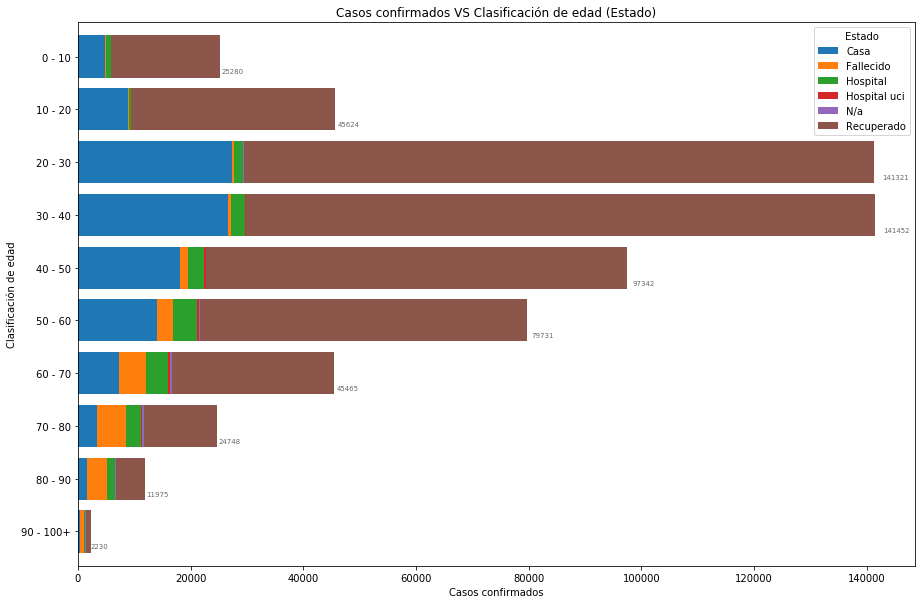

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  4881         34       875            50   32   
10 - 20                 8968         32       438            27   24   
20 - 30                27363        255      1673            82   57   
30 - 40                26577        639      2452           186   48   
40 - 50                18037       1433      2916           278   95   
50 - 60                13981       2962      4131           463  155   
60 - 70                 7302       4732      3907           436  260   
70 - 80                 3412       5028      2678           267  307   
80 - 90                 1521       3706      1292            68  249   
90 - 100+                288        842       185             7   62   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      19408  
10 - 20                     36135  
20 - 30                    111891  
30 - 40                    111550  
40 - 50                     74583  
50 - 60                     58039  
60 - 70                     28828  
70 - 80                     13056  
80 - 90                      5139  
90 - 100+                     846

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

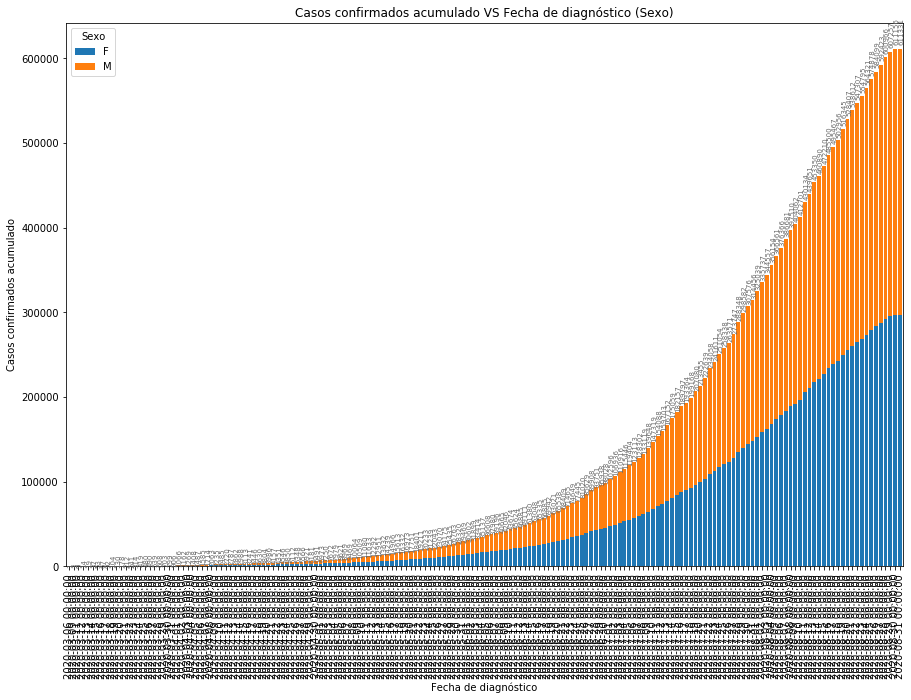

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-31            297243.0  314088.0
2020-08-30            297151.0  314005.0
2020-08-29            295127.0  312130.0
2020-08-28            291917.0  309049.0
2020-08-27            287619.0  304804.0
2020-08-26            283434.0  300665.0
2020-08-25            278710.0  296168.0
2020-08-24            273401.0  290920.0
2020-08-23            268636.0  286159.0
2020-08-22            264828.0  282479.0
2020-08-21            260724.0  277888.0
2020-08-20            255579.0  272828.0
2020-08-19            249504.0  266841.0
2020-08-18            242551.0  260405.0
2020-08-17            238942.0  256525.0
2020-08-16            233672.0  251828.0
2020-08-15            226724.0  245486.0
2020-08-14            220972.0  239918.0
2020-08-13            217114.0  236236.0
2020-08-12            210255.0  229396.0
2020-08-11            205537.0  224597.0
2020-08-10            196504.0  216197.0
2020-08-09            192167.0  211895.0
2020-08-08            188790.0  208720.0
2020-08-07            183519.0  203162.0
2020-08-06            178480.0  197886.0
2020-08-05            173625.0  192936.0
2020-08-04            168414.0  187740.0
2020-08-03            162601.0  181956.0
2020-08-02            158333.0  177404.0
2020-08-01            152863.0  172176.0
2020-07-31            147743.0  166713.0
2020-07-30            144294.0  163282.0
2020-07-29            139921.0  158661.0
2020-07-28            134842.0  153506.0
2020-07-27            127730.0  146017.0
2020-07-26            122854.0  140717.0
2020-07-25            120456.0  137882.0
2020-07-24            116769.0  134285.0
2020-07-23            112403.0  129208.0
2020-07-22            108834.0  125224.0
2020-07-21            103670.0  118969.0
2020-07-20             99366.0  114089.0
2020-07-19             96390.0  110690.0
2020-07-18             92601.0  106567.0
2020-07-17             89820.0  103544.0
2020-07-16             88063.0  101734.0
2020-07-15             84314.0   97843.0
2020-07-14             80941.0   94118.0
2020-07-13             77345.0   89807.0
2020-07-12             73774.0   85929.0
2020-07-11             71100.0   82988.0
2020-07-10             67886.0   79433.0
2020-07-09             64382.0   75266.0
2020-07-08             61419.0   71700.0
2020-07-07             59109.0   69193.0
2020-07-06             56700.0   66413.0
2020-07-05             54947.0   64457.0
2020-07-04             53113.0   62333.0
2020-07-03             51084.0   59832.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

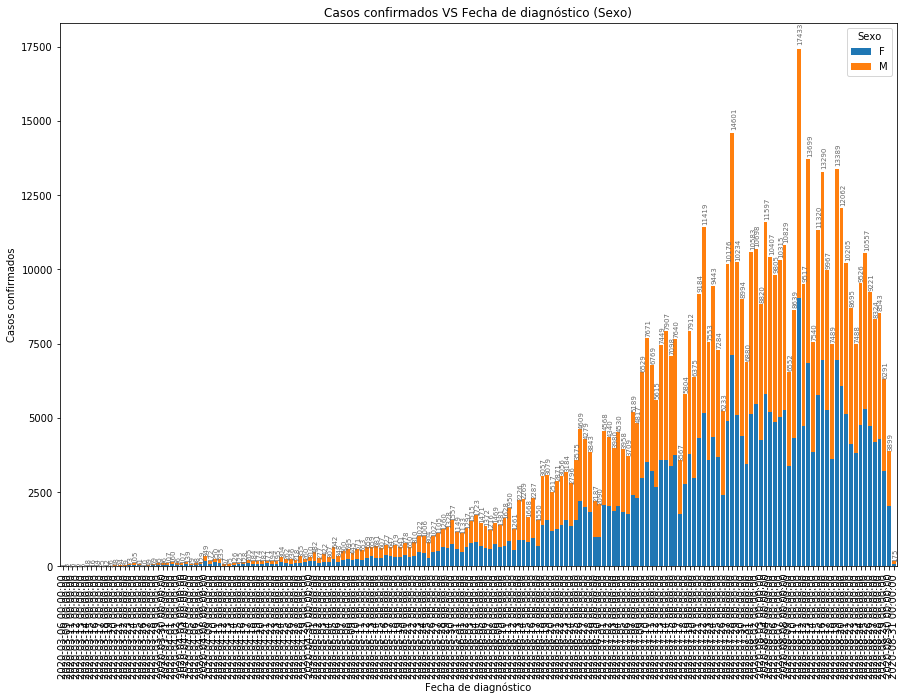

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-31              92.0    83.0
2020-08-30            2024.0  1875.0
2020-08-29            3210.0  3081.0
2020-08-28            4298.0  4245.0
2020-08-27            4185.0  4139.0
2020-08-26            4724.0  4497.0
2020-08-25            5309.0  5248.0
2020-08-24            4765.0  4761.0
2020-08-23            3808.0  3680.0
2020-08-22            4104.0  4591.0
2020-08-21            5145.0  5060.0
2020-08-20            6075.0  5987.0
2020-08-19            6953.0  6436.0
2020-08-18            3609.0  3880.0
2020-08-17            5270.0  4697.0
2020-08-16            6948.0  6342.0
2020-08-15            5752.0  5568.0
2020-08-14            3858.0  3682.0
2020-08-13            6859.0  6840.0
2020-08-12            4718.0  4799.0
2020-08-11            9033.0  8400.0
2020-08-10            4337.0  4302.0
2020-08-09            3377.0  3175.0
2020-08-08            5271.0  5558.0
2020-08-07            5039.0  5276.0
2020-08-06            4855.0  4950.0
2020-08-05            5211.0  5196.0
2020-08-04            5813.0  5784.0
2020-08-03            4268.0  4552.0
2020-08-02            5470.0  5228.0
2020-08-01            5120.0  5463.0
2020-07-31            3449.0  3431.0
2020-07-30            4373.0  4621.0
2020-07-29            5079.0  5155.0
2020-07-28            7112.0  7489.0
2020-07-27            4876.0  5300.0
2020-07-26            2398.0  2835.0
2020-07-25            3687.0  3597.0
2020-07-24            4366.0  5077.0
2020-07-23            3569.0  3984.0
2020-07-22            5164.0  6255.0
2020-07-21            4304.0  4880.0
2020-07-20            2976.0  3399.0
2020-07-19            3789.0  4123.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3749.0  3891.0
2020-07-15            3373.0  3725.0
2020-07-14            3596.0  4311.0
2020-07-13            3571.0  3878.0
2020-07-12            2674.0  2941.0
2020-07-11            3214.0  3555.0
2020-07-10            3504.0  4167.0
2020-07-09            2963.0  3566.0
2020-07-08            2310.0  2507.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2501.0
2020-07-03            1856.0  2124.0

### - Casos confirmados VS Clasificación de edad (Sexo)

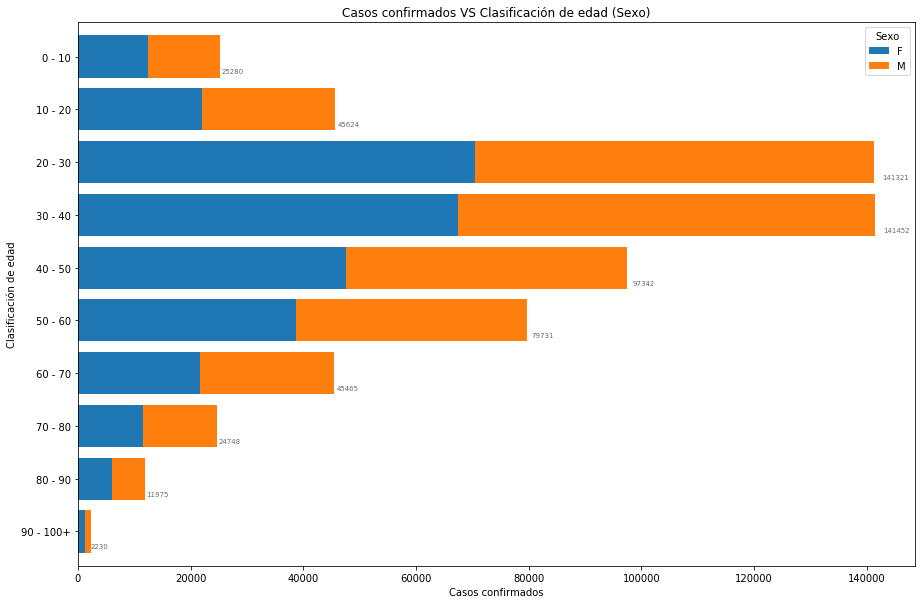

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 12364  12916
10 - 20                21982  23642
20 - 30                70470  70851
30 - 40                67441  74011
40 - 50                47647  49695
50 - 60                38651  41080
60 - 70                21587  23878
70 - 80                11550  13198
80 - 90                 6102   5873
90 - 100+               1264    966

### - Casos confirmados VS Estado (Sexo)

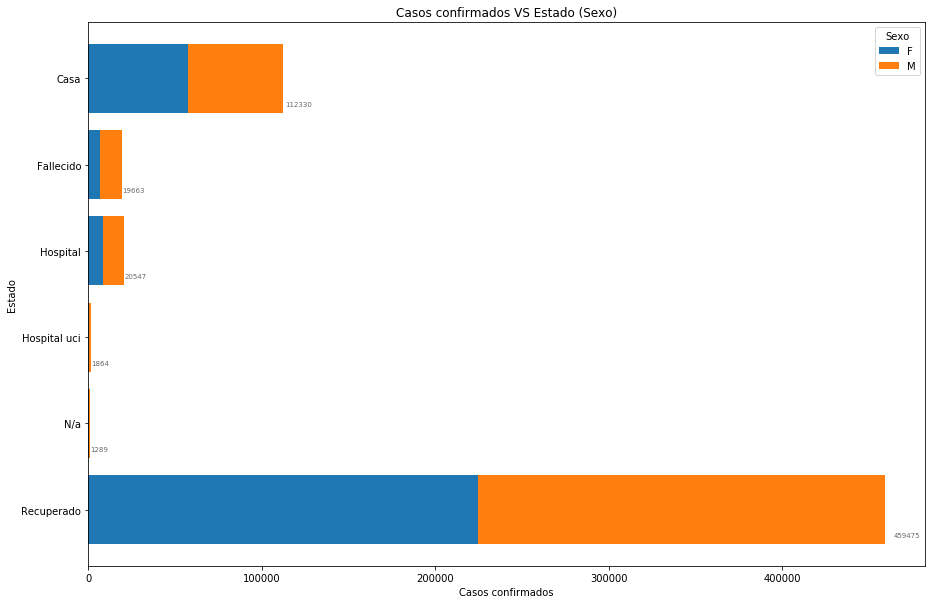

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           57503   54827
Fallecido       7042   12621
Hospital        8753   11794
Hospital uci     654    1210
N/a              558     731
Recuperado    224548  234927

### - Casos confirmados VS Tipo de contagio (Sexo)

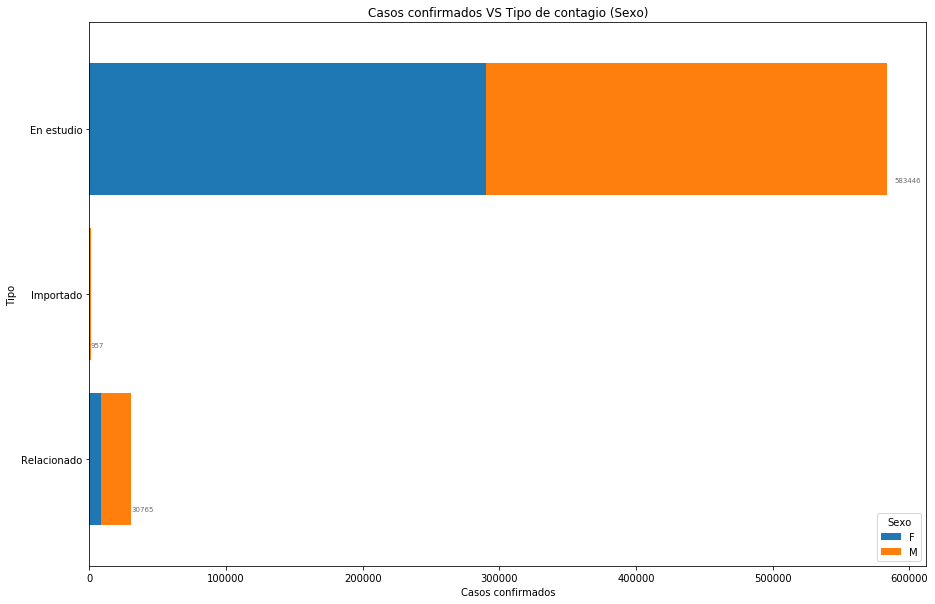

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   289972  293474
Importado       450     507
Relacionado    8636   22129

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

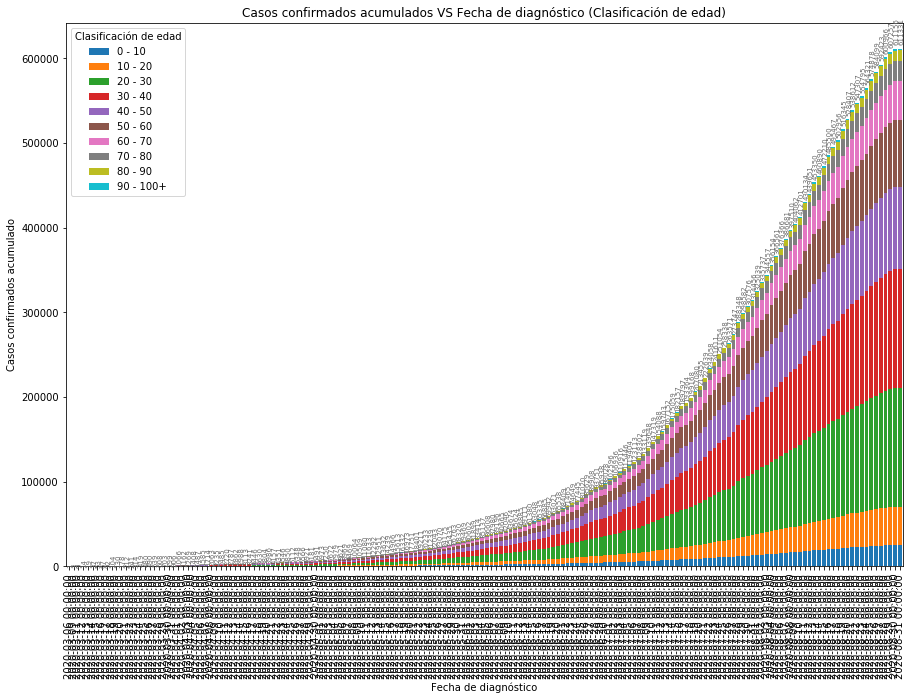

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-31              25145    45348   140412   140526    96777    79260   
2020-08-30              25133    45332   140379   140493    96760    79227   
2020-08-29              24958    45049   139456   139642    96180    78706   
2020-08-28              24723    44594   137998   138256    95210    77829   
2020-08-27              24410    44011   136087   136250    93869    76703   
2020-08-26              24075    43401   134153   134351    92541    75652   
2020-08-25              23734    42702   132181   132255    91055    74497   
2020-08-24              23350    42016   129775   129781    89337    73091   
2020-08-23              22990    41311   127562   127639    87847    71862   
2020-08-22              22681    40704   125762   125893    86737    70878   
2020-08-21              22363    40050   123758   123822    85429    69779   
2020-08-20              21945    39313   121329   121504    83814    68444   
2020-08-19              21460    38460   118681   118796    81899    66835   
2020-08-18              20832    37482   115674   115795    79702    65140   
2020-08-17              20580    36970   114005   114104    78505    64116   
2020-08-16              20066    36210   111798   112007    76914    62782   
2020-08-15              19448    35075   108840   109112    74798    61035   
2020-08-14              18948    34237   106232   106612    73015    59512   
2020-08-13              18694    33699   104498   104937    71795    58454   
2020-08-12              18071    32635   101400   101834    69607    56649   
2020-08-11              17724    32000    99318    99630    68094    55387   
2020-08-10              16930    30749    95206    95595    65259    53138   
2020-08-09              16599    30068    93255    93590    63905    52022   
2020-08-08              16355    29641    91747    92161    62823    51140   
2020-08-07              15939    28857    89309    89520    61117    49719   
2020-08-06              15525    28086    86949    87087    59479    48383   
2020-08-05              15076    27341    84770    84846    57909    47109   
2020-08-04              14649    26615    82386    82437    56220    45744   
2020-08-03              14160    25797    79728    79726    54317    44160   
2020-08-02              13836    25188    77729    77676    52970    42942   
2020-08-01              13393    24468    75318    75281    51163    41441   
2020-07-31              12979    23613    72763    72772    49542    40097   
2020-07-30              12706    23156    71233    71135    48367    39248   
2020-07-29              12362    22443    69051    69003    47040    38072   
2020-07-28              11980    21697    66625    66529    45354    36827   
2020-07-27              11351    20561    63298    63241    43037    34894   
2020-07-26              10965    19839    60910    60856    41367    33681   
2020-07-25              10755    19514    59721    59629    40553    33000   
2020-07-24              10471    19030    58084    57925    39387    32010   
2020-07-23              10150    18309    55879    55636    37910    30776   
2020-07-22               9873    17793    54195    53888    36709    29786   
2020-07-21               9467    16945    51473    51299    34923    28241   
2020-07-20               9107    16318    49308    49118    33439    27089   
2020-07-19               8829    15858    47953    47658    32369    26260   
2020-07-18               8516    15198    46119    45802    31059    25278   
2020-07-17               8294    14856    44825    44386    30102    24526   
2020-07-16               8171    14637    44023    43525    29555    24072   
2020-07-15               7829    14126    42310    41712    28302    23050   
2020-07-14               7534    13589    40700    40097    27171    22115   
2020-07-13            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

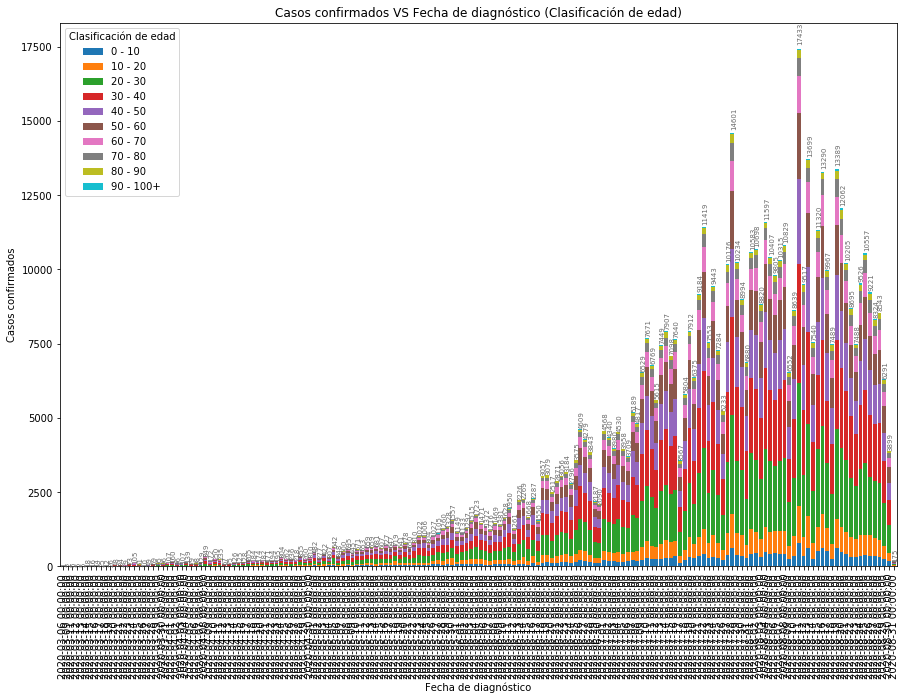

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-31                 12       16       33       33       17       33   
2020-08-30                175      283      923      851      580      521   
2020-08-29                235      455     1458     1386      970      877   
2020-08-28                313      583     1911     2006     1341     1126   
2020-08-27                335      610     1934     1899     1328     1051   
2020-08-26                341      699     1972     2096     1486     1155   
2020-08-25                384      686     2406     2474     1718     1406   
2020-08-24                360      705     2213     2142     1490     1229   
2020-08-23                309      607     1800     1746     1110      984   
2020-08-22                318      654     2004     2071     1308     1099   
2020-08-21                418      737     2429     2318     1615     1335   
2020-08-20                485      853     2648     2708     1915     1609   
2020-08-19                628      978     3007     3001     2197     1695   
2020-08-18                252      512     1669     1691     1197     1024   
2020-08-17                514      760     2207     2097     1591     1334   
2020-08-16                618     1135     2958     2895     2116     1747   
2020-08-15                500      838     2608     2500     1783     1523   
2020-08-14                254      538     1734     1675     1220     1058   
2020-08-13                623     1064     3098     3103     2188     1805   
2020-08-12                347      635     2082     2204     1513     1262   
2020-08-11                794     1251     4112     4035     2835     2249   
2020-08-10                331      681     1951     2005     1354     1116   
2020-08-09                244      427     1508     1429     1082      882   
2020-08-08                416      784     2438     2641     1706     1421   
2020-08-07                414      771     2360     2433     1638     1336   
2020-08-06                449      745     2179     2241     1570     1274   
2020-08-05                427      726     2384     2409     1689     1365   
2020-08-04                489      818     2658     2711     1903     1584   
2020-08-03                324      609     1999     2050     1347     1218   
2020-08-02                443      720     2411     2395     1807     1501   
2020-08-01                414      855     2555     2509     1621     1344   
2020-07-31                273      457     1530     1637     1175      849   
2020-07-30                344      713     2182     2132     1327     1176   
2020-07-29                382      746     2426     2474     1686     1245   
2020-07-28                629     1136     3327     3288     2317     1933   
2020-07-27                386      722     2388     2385     1670     1213   
2020-07-26                210      325     1189     1227      814      681   
2020-07-25                284      484     1637     1704     1166      990   
2020-07-24                321      721     2205     2289     1477     1234   
2020-07-23                277      516     1684     1748     1201      990   
2020-07-22                406      848     2722     2589     1786     1545   
2020-07-21                360      627     2165     2181     1484     1152   
2020-07-20                278      460     1355     1460     1070      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      511     1713     1813     1253     1022   
2020-07-15                295      537     1610     1615     1131      935   
2020-07-14                296      584     1868     1879     1277      976   
2020-07-13            

### - Casos confirmados VS Estado (Clasificación de edad)

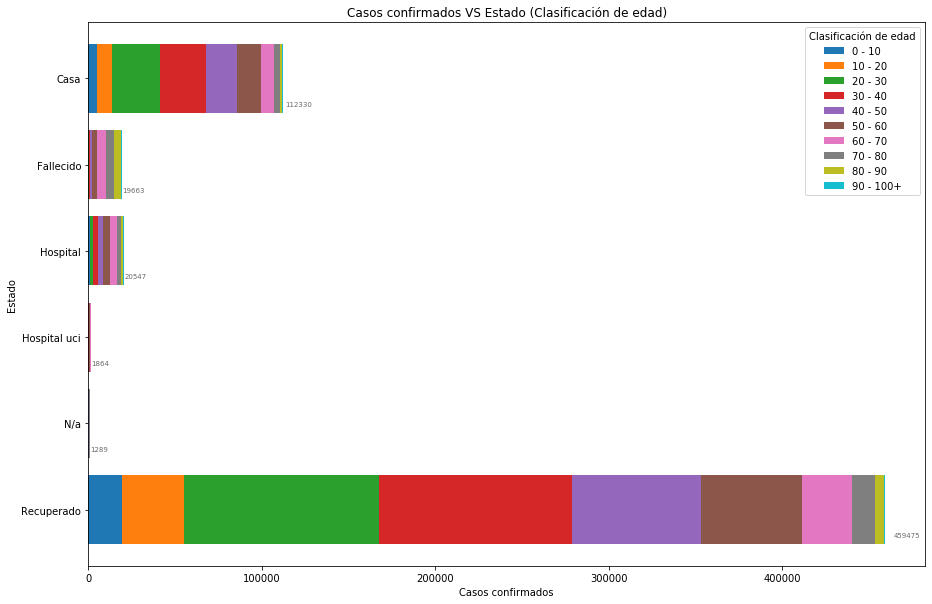

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     4881     8968    27363    26577    18037    13981   
Fallecido                  34       32      255      639     1433     2962   
Hospital                  875      438     1673     2452     2916     4131   
Hospital uci               50       27       82      186      278      463   
N/a                        32       24       57       48       95      155   
Recuperado              19408    36135   111891   111550    74583    58039   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7302     3412     1521        288  
Fallecido                 4732     5028     3706        842  
Hospital                  3907     2678     1292        185  
Hospital uci               436      267       68          7  
N/a                        260      307      249         62  
Recuperado               28828    13056     5139        846

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

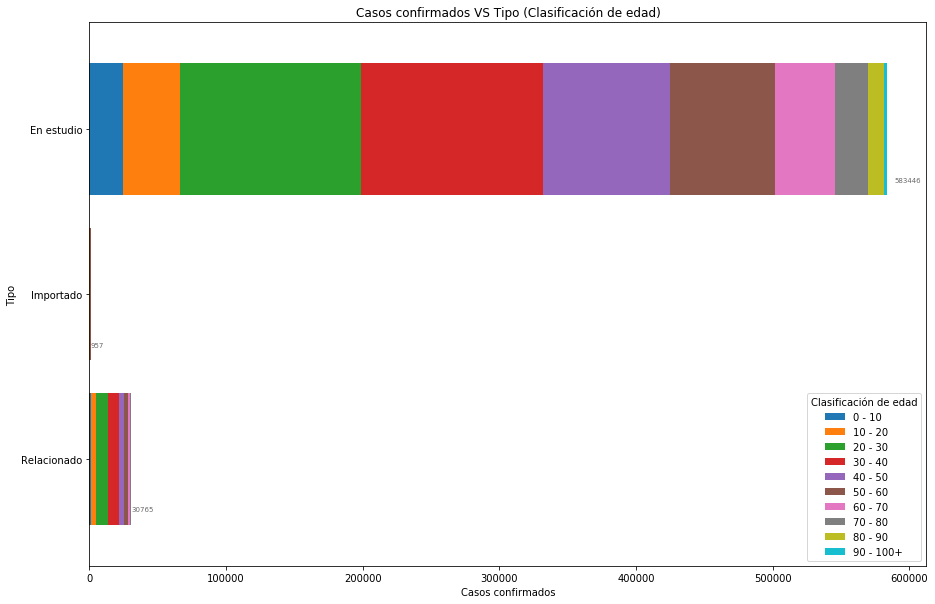

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              24262    41773   132444   133288    93268    76899   
Importado                   5       37      239      222      169      144   
Relacionado              1013     3814     8638     7942     3905     2688   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               43967    24009    11439       2097  
Importado                   95       36        9          1  
Relacionado               1403      703      527        132

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>